In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
np.random.seed(42)


# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def save_fig(fig_id, tight_layout=True):
    path = os.path.join("FTKToyWithModulesPlots", fig_id + ".pdf")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='pdf', dpi=300)

In [2]:
rDet         = np.array([0.5, 1.0, 1.5, 2, 2.5,3.0])
nModPerLayer = np.array([14,   28,  42, 56, 70, 84])

xDet = np.linspace(-3, 3, 5000)
yDet = np.sqrt(0.5**2-xDet**2)

/Users/johnda/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


# Helper Functions

In [3]:
# Note there are 2 different phis used:
#   - phi_circle (the angle of the center of the circle in r-phi plane)
#   - phi_track (the direction of the particle that made the track) 
#
#  For positive tracks: phi_circle = phi_track - pi/2
#  For negative tracks: phi_circle = phi_track + pi/2
from TrackHelper import getPhiCircle
from TrackHelper import drawTrack

# Now Detector Classes


In [4]:
from detectorGeo import detectorGeo

Saving figure Detector


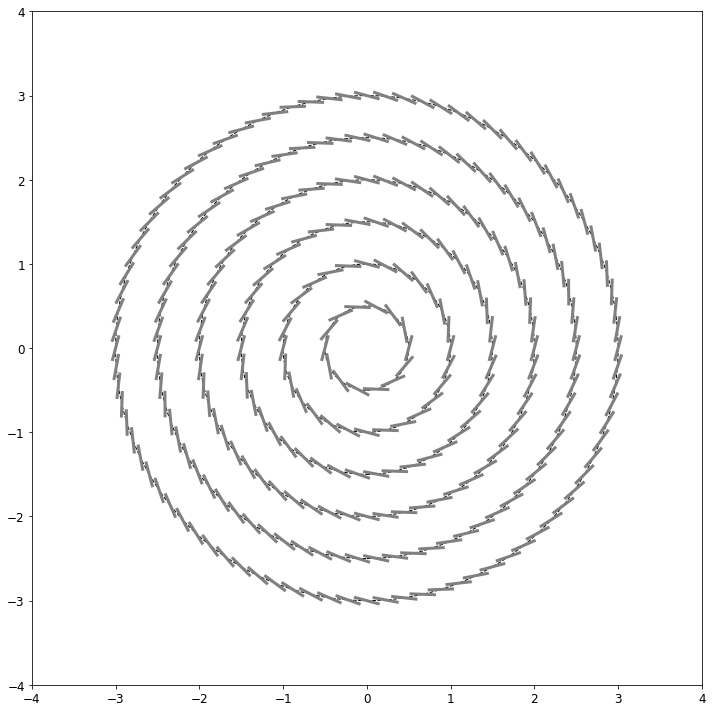

In [5]:

fig, ax = plt.subplots(1, figsize=(10,10))
zoom = 4
ax.set_xlim((-1*zoom, zoom))
ax.set_ylim((-1*zoom, zoom))

detGeo = detectorGeo()
detGeo.initSimple(rDet,nModPerLayer)

detGeo.drawDetector(ax,detailed=True)
save_fig("Detector")

# Make some Towers

OK move to a phi slice and start with FTK. Lets draw the SSIDs

Saving figure TowerPhi0


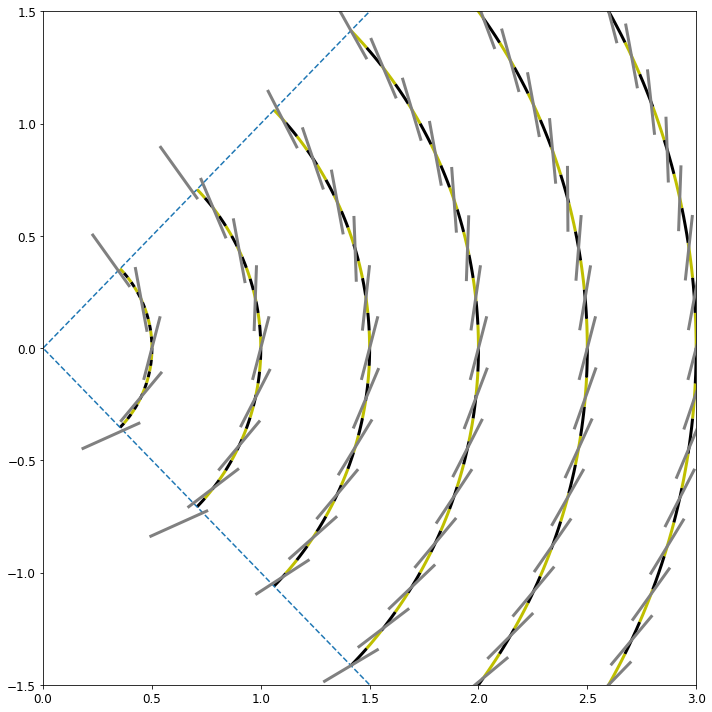

In [6]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((0, 3))
ax.set_ylim((-1.5, 1.5))
nSSperLayer=[30,30,30,30,30,30]


detGeo.makeTower(phiCenter=0*np.pi/12,  phiWidth=np.pi/2, nSS=nSSperLayer)


doPlotsWithLines = False
if doPlotsWithLines:
    detGeo.drawTower(ax,detailed=False,drawPSLayer=True)
    plt.plot([0,3*np.cos(np.pi/8)],[0,3*np.sin(np.pi/8)],"r:")
    plt.plot([0,3],[0,0],"r")
    plt.plot([0,3*np.cos(-np.pi/8)],[0,3*np.sin(-np.pi/8)],"r:")
    save_fig("TowerPhi0WithLines")
else:
    detGeo.drawTower(ax,detailed=True)
    save_fig("TowerPhi0")
    

# Get sometracks for pattern matching

In [7]:
np.random.seed(42)

solutions_test  = []

phiRange = (-3*np.pi/12, 3*np.pi/12)

for trkI in range(10):
    
    ptInv = np.random.uniform(0.01,0.5,1)[0]
    phi   = np.random.uniform(phiRange[0],phiRange[1],1)[0]
    q     = 2*np.random.randint(0,2,1)[0]-1
    pt = 1./ptInv

    xHits, yHits, modulesHit, actualHits = detGeo.getHits(pt,phi,q)

    solutions_test.append([xHits,yHits,pt,phi,q,modulesHit,actualHits])


/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:133: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:134: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:135: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:136: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))


# Lets plot the SSIDs that are Hit as a sanity check

In [8]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((0, 3))
ax.set_ylim((-1.5, 1.5))

detGeo.drawTower(ax,detailed=False)
for sItr in range(10):
    s = solutions_test[sItr]

    if not detGeo.hitsAllInTower(s[6]): continue
    
    color = "b" if (s[4] < 0) else "r"
    plt.plot(s[0],s[1],color)
    
    hitList = []
    realHits = s[6]
    for rHit in realHits:
        # hitID / hit-X / hit-Y / hit-Z/ volume_id /  layer_id 
        hitList.append(  [1,rHit[1],rHit[2], None, rHit[0][0], rHit[0][1] ] )
        
        
    #print(s[6])
    hitsWithSSIDs = detGeo.addSSIDs(hitList)

    # Get to format of logicallayer_id / SSID
    thisSSIDs = np.array(hitsWithSSIDs)[:,6:8]
    plt.plot(s[0],s[1],'ko')
    
    detGeo.drawSSIDs(ax,thisSSIDs)
    
    #print(hits)
    for rH in realHits:
        plt.plot(rH[1],rH[2],'bo')




OK now we are cooking with GAS

# OK Lets make some patterns 

In [9]:
from TrackHelper import patternID

In [10]:
import os
import pickle
if os.path.isfile("patternsSimpleGeo_75k.pickle"):
    print("Loading Patterns")
    with open('patternsSimpleGeo_75k.pickle', 'rb') as handle:
        patternsBankLoaded = pickle.load(handle)
    
    patternBank         = patternsBankLoaded["bank"]
    passedTracksSamples = patternsBankLoaded["passedTracks"]
    patternBankSize     = patternsBankLoaded["bankSize"]


else:
    print("Making Patterns")
    
    np.random.seed(42)
    
    nTrk_pattGen = int(7.5e2)#int(7.5e2)
    solutions_pattGen  = []

    phiRange = (-3*np.pi/12, 3*np.pi/12)


    for trkI in range(nTrk_pattGen):
        
        ptInv = np.random.uniform(0.01,0.5,1)[0]
        phi   = np.random.uniform(phiRange[0],phiRange[1],1)[0]
        q     = 2*np.random.randint(0,2,1)[0]-1
        pt = 1./ptInv
        
        xHits, yHits, modulesHit, actualHits = detGeo.getHits(pt,phi,q)
        
        solutions_pattGen.append([xHits,yHits,pt,phi,q,modulesHit,actualHits])

    # The pattern bank
    patternBank = {}
    
    # For plotting
    passedTracks = 0
    passedTracksSamples = np.array([],float)
    patternBankSize = np.array([],float)
    
    for sItr in range(nTrk_pattGen):
        s = solutions_pattGen[sItr]

        if not detGeo.hitsAllInTower(s[6]): continue

        hitList = []
        realHits = s[6]
        for rHit in realHits:
            # hitITr / hit-X / hit-Y / hit-Z / volumeID / layerID 
            hitList.append(  [1,rHit[1],rHit[2], None, rHit[0][0], rHit[0][1] ] )

            
        passedTracks += 1
        
        hitsWithSSIDs = detGeo.addSSIDs(hitList)
        
        # Get SSIds perlayer
        thisSSIDs = [] 
        for _ in range(len(rDet)): thisSSIDs.append([])
            
        for hinfo in hitsWithSSIDs:
            thisSSIDs[hinfo[6]].append(hinfo[7])
        
        #
        #  Need one SSIDS per layer
        #        
        goodTrack = True
        for layItr, layerSSIDs in enumerate(thisSSIDs):
            if len(layerSSIDs) == 0:  
                #print("Using PS hit instead")
                #thisSSIDs[layItr].append()
                goodTrack = False
                #fig, ax = plt.subplots(1, figsize=(10,10))
                #ax.set_xlim((0, 3))
                #ax.set_ylim((-1.5, 1.5))
                
                #detGeo.drawTower(ax,detailed=True)
                #color = "b" if (s[4] < 0) else "r"
                #plt.plot(s[0],s[1],color)
                
            elif len(layerSSIDs) == 1:  
                pass # all good
            else:
                while(not len(thisSSIDs[layItr]) == 1):
                    thisSSIDs[layItr].pop(-1)
        if not goodTrack: continue
        thisPatternID = patternID(thisSSIDs,nSSperLayer)
        
        if thisPatternID not in patternBank:
            patternBank[thisPatternID] = 0
        
        patternBank[thisPatternID] += 1
        
        # Statistics
        if passedTracks %10 == 0:
            passedTracksSamples = np.append(passedTracksSamples,passedTracks)
            patternBankSize     = np.append(patternBankSize, len(patternBank))
    
    
    patternsBankToLoad = {}
    patternsBankToLoad["bank"]         = patternBank
    patternsBankToLoad["passedTracks"] = passedTracksSamples
    patternsBankToLoad["bankSize"]     = patternBankSize

    with open('patternsSimpleGeo_75k.pickle', 'wb') as handle:
        pickle.dump(patternsBankToLoad, handle, protocol=pickle.HIGHEST_PROTOCOL)

len(patternBank)

Loading Patterns


3210

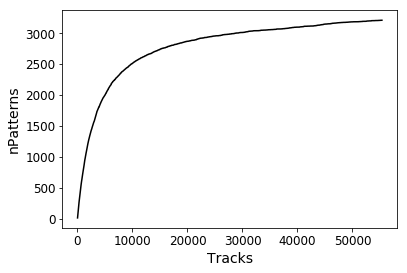

In [11]:
plt.plot(passedTracksSamples,patternBankSize,"k")
plt.xlabel("Tracks")
plt.ylabel("nPatterns")

# OK Lets try to do pattern matching with the pattern bank

Make an event with tracks

In [12]:
def getEvent(nTrks, phiCenter, phiWidth, det_geo, randSeed = 42, debug=False):
    np.random.seed(randSeed)

    # Kaggle formats
    eventParticles = []
    eventTruth = []
    eventHits = []

    # For plotting 
    solutions = []
    
    hitID = 0
    trkID = 0
    phiRange = (phiCenter-phiWidth/2, phiCenter+phiWidth/2)

    if debug: print("phiRange is",phiRange)
    nTrkPerPhiRegion = int(10) # with 50 tracks total ~10 in a phi slice
    for trkI in range(nTrks):
        ptInv = np.random.uniform(0.01,0.5,1)[0]
        phi   = np.random.uniform(phiRange[0],phiRange[1],1)[0]
        q     = 2*np.random.randint(0,2,1)[0]-1
        pt = 1./ptInv

        xHits, yHits, modulesHit, actualHits = det_geo.getHits(pt,phi,q)

        if not det_geo.hitsAllInTower(actualHits): 
            if debug: print("Skipping",phi)
            continue
        

        trkID += 1
        eventParticles.append((trkI,pt,phi,q,6))
        solutions.append([xHits,yHits,pt,phi,q,modulesHit,actualHits])
        for thisHit in actualHits:
            # hit_id, particle_id, tx, ty, tz, weight (=1 for now)
            eventTruth.append([hitID,trkID,thisHit[1],thisHit[2],None,1.0])
            eventHits .append((hitID,thisHit[1],thisHit[2],None,thisHit[0][0],thisHit[0][1],thisHit[0][2])) 
            hitID += 1


    recHits = np.array(eventHits)
    shuffle_index = np.random.permutation(len(recHits))
    recHits = recHits[shuffle_index]

    return recHits, eventTruth, eventParticles, solutions

In [13]:
recHits, eventTruth, eventPartilces, solutions = getEvent(10, 0, np.pi/4, detGeo)

recHits[0:10] 

/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:135: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:136: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:133: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:134: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))


array([[52, 1.329801534197519, -0.767147271358888, None, 0, 2, 38],
       [0, 0.4549505452240632, 0.1933379038387164, None, 0, 0, 1],
       [26, 1.9922854848890754, -0.21154316032272025, None, 0, 3, 55],
       [22, 0.4694109266213752, -0.11415997600548033, None, 0, 0, 0],
       [12, 2.271061006576419, -1.0630506264727506, None, 0, 4, 65],
       [57, 2.1566110488764787, -2.0672507362998065, None, 0, 5, 74],
       [10, 1.4417271932062719, -0.31872606385733615, None, 0, 2, 41],
       [18, 1.82203192949486, -0.8444176015502354, None, 0, 3, 52],
       [4, 2.0519730825585674, 1.3927938053058844, None, 0, 4, 7],
       [32, 1.8858552929301629, 0.6860635531609347, None, 0, 3, 3]],
      dtype=object)

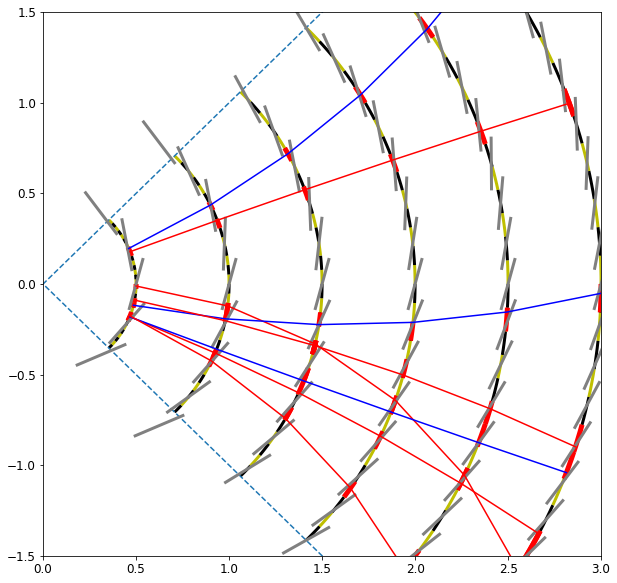

In [14]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((0, 3))
ax.set_ylim((-1.5, 1.5))

detGeo.drawTower(ax,detailed=True)
for sItr in range(len(solutions)):
    s = solutions[sItr]

    hitListTrk = []

    realHits = s[6]
    for rHit in realHits:
        # hitITr / hit-X / hit-Y / hit-Z / volumeID / layerID 
        hitListTrk.append(  [1,rHit[1],rHit[2], None, rHit[0][0], rHit[0][1] ] )

        
    color = "b" if (s[4] < 0) else "r"
    plt.plot(s[0],s[1],color)
    
    hitsWithSSIDs = detGeo.addSSIDs(hitListTrk)

    
    # Get to format of logicallayer_id / SSID
    thisSSIDs = np.array(hitsWithSSIDs)[:,6:8]
    
    detGeo.drawSSIDs(ax,thisSSIDs)


OK now loop over hits get SSIDS and match patterns

In [15]:
#print(recHits[0])
hitsAndSSIDS = detGeo.addSSIDs(recHits,debug=False)
#print(hitsAndSSIDS[0])
detGeo.DOWrite(hitsAndSSIDS)

In [16]:
patterns = patternBank.keys()
matchedPatterns = []
for p in patterns:

    if detGeo.isPatternFired(p): 
        matchedPatterns.append(p)

print(matchedPatterns)

[272625242322, 50606070708, 90808080707, 203050608, 90908080707, 212121212122, 212121212121, 40608101214, 90910101111, 203050708, 203050607, 103050708, 272625242321, 80910101111, 141312121110, 80808080707, 90808070707, 80808070707, 141312121111, 50608101214, 50606070707, 103050608]


In [17]:
from TrackHelper import getSSIDS

272625242322
50606070708
90808080707
203050608
90908080707
212121212122
212121212121
40608101214
90910101111
203050708
203050607
103050708
272625242321
80910101111
141312121110
80808080707
90808070707
80808070707
141312121111
50608101214
50606070707
103050608
Saving figure MatchedPatternsPhi0


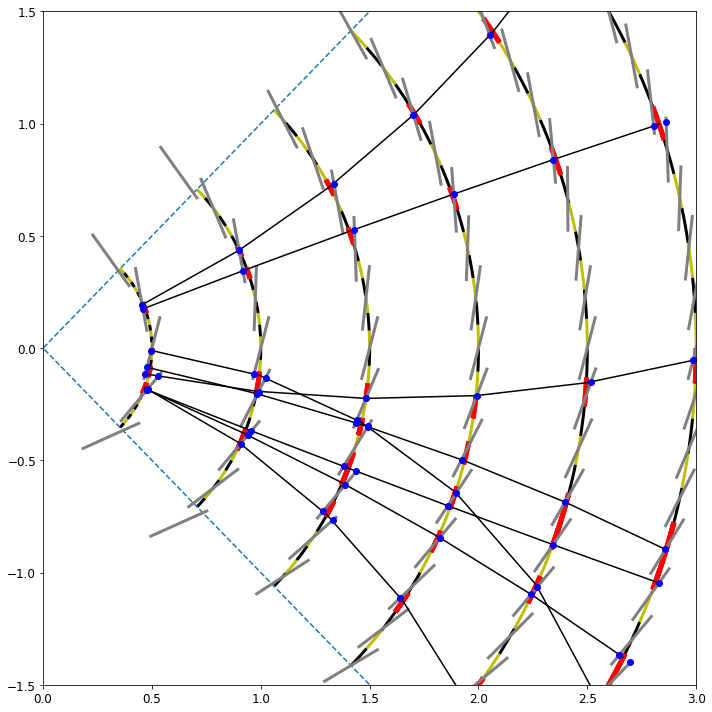

In [18]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((0, 3))
ax.set_ylim((-1.5, 1.5))


detGeo.drawTower(ax,detailed=True)
for mp in matchedPatterns:
    print(mp)            
    thisSSIDs = getSSIDS(mp)
    detGeo.drawSSIDs(ax,thisSSIDs)
    
for sItr in range(len(solutions)):
    s = solutions[sItr]

    color = "k"
    plt.plot(s[0],s[1],color)
    
    realHits = s[6]
    for rHit in realHits:
        plt.plot(rHit[1],rHit[2],"bo")

    
save_fig("MatchedPatternsPhi0")

In [19]:
solns, _  = detGeo.getSolutions(matchedPatterns)
solns.head()
solns

event_id  hit_id  track_id
0          0       0         1
1          0       1         1
2          0       2         1
3          0       3         1
4          0       4         1
5          0       5         1
6          0      50         2
7          0      44         2
8          0      16         2
9          0      17         2
10         0      18         2
11         0      12         2
12         0      19         2
13         0      21         2
14         0      20         2
15         0      15         3
16         0      43         3
17         0      45         3
18         0      46         3
19         0      11         3
20         0      47         3
21         0      48         3
22         0      42         3
23         0      51         4
24         0      52         4
25         0      53         4
26         0      54         4
27         0      56         4
28         0      57         4
29         0      30         6
30         0      31         6
31         0      32         6
32         0      33         6
33         0      35         6
34         0      34         6
35         0       6         8
36         0       7         8
37         0       8         8
38         0      10         8
39         0       9         8
40         0      39         8
41         0      38         8
42         0      14         8
43         0      13         8
44         0      36         9
45         0      37         9
46         0      24         9
47         0      40         9
48         0      41         9
49         0      22        15
50         0      23        15
51         0      25        15
52         0      26        15
53         0      27        15
54         0      28        15

In [20]:
from TrackHelper import getTruthDF


In [21]:
truth = getTruthDF(eventTruth)
truth.head()

hit_id particle_id weight
0      0           1      1
1      1           1      1
2      2           1      1
3      3           1      1
4      4           1      1

In [22]:
import score
score.score_event(truth,solns)

0.7931034482758621

Giddy up

# OK see if we can get the a differnet region of phi working with the same pattern bank

Saving figure TowerPhi0p5Pi


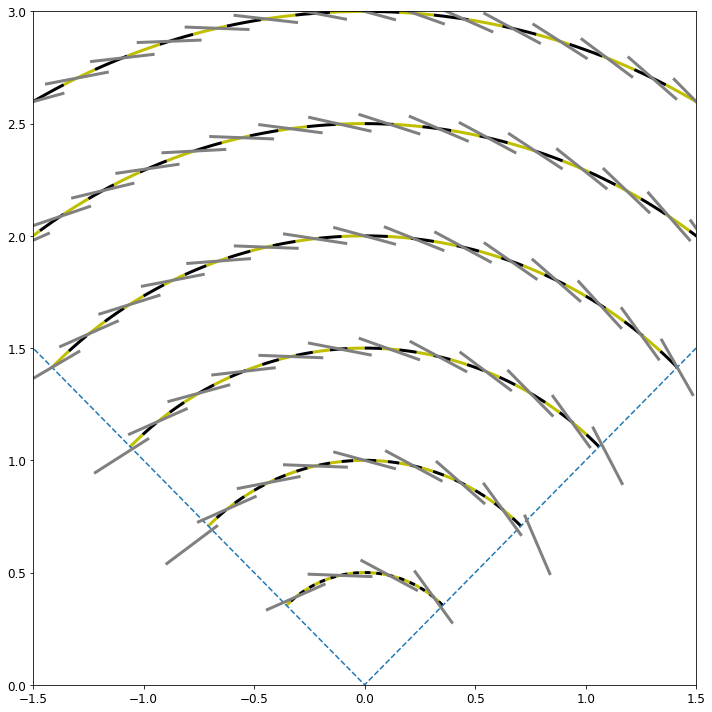

In [23]:
detGeo_up = detectorGeo()
detGeo_up.initSimple(rDet,nModPerLayer)
detGeo_up.makeTower(np.pi/2,  np.pi/2, nSS=nSSperLayer)

fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((-1.5, 1.5))
ax.set_ylim((0, 3))

#detGeo_up.drawTower(ax,detailed=True)


doPlotsWithLines = False
if doPlotsWithLines:
    detGeo_up.drawTower(ax,detailed=False,drawPSLayer=True)
    plt.plot([0,3*np.cos(np.pi/2+np.pi/8)],[0,3*np.sin(np.pi/2+np.pi/8)],"r:")
    plt.plot([0,3*np.cos(np.pi/2)],[0,3*np.sin(np.pi/2)],"r")
    plt.plot([0,3*np.cos(np.pi/2-np.pi/8)],[0,3*np.sin(np.pi/2-np.pi/8)],"r:")
    save_fig("TowerPhi0p5PiWithLines")
else:
    detGeo_up.drawTower(ax,detailed=True)
    save_fig("TowerPhi0p5Pi")


In [24]:
#np.random.seed(24)
recHits_up, eventTruth_up, eventPartilces_up, solutions_up = getEvent(10, np.pi/2, np.pi/4, detGeo_up)
recHits_up[0:10]

/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:133: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:134: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:135: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:136: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))


array([[52, 0.17090831674610374, 0.45593914706114935, None, 0, 0, 3],
       [0, -0.21100746307298926, 0.49119622535840074, None, 0, 0, 4],
       [26, 0.22473307939577886, 1.520025588933204, None, 0, 2, 9],
       [22, 1.4004067803965556, 2.6976694309567604, None, 0, 5, 14],
       [12, 0.6454924132388312, 1.8980382882310003, None, 0, 3, 11],
       [57, 2.0672507362998047, 2.1566110488764796, None, 0, 5, 11],
       [10, 0.11345596113623384, 0.9695995668370493, None, 0, 1, 7],
       [18, 0.594244882597563, 1.3621888607389097, None, 0, 2, 8],
       [4, -1.0385896558277328, 1.7013062401831394, None, 0, 3, 19],
       [32, -0.34466381552292114, 0.9178501882387922, None, 0, 1, 9]],
      dtype=object)

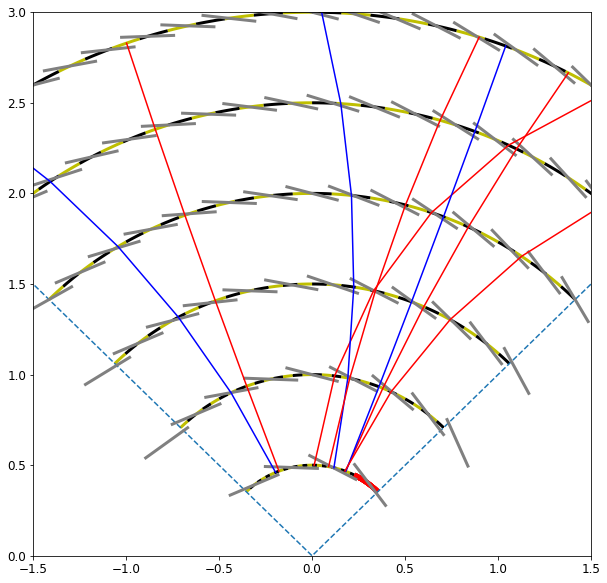

In [25]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((-1.5, 1.5))
ax.set_ylim((0, 3))

detGeo_up.drawTower(ax,detailed=True)
for sItr in range(len(solutions_up)):
    s = solutions_up[sItr]

    hitListTrk = []

    realHits = s[6]
    for rHit in realHits:
        # hitITr / hit-X / hit-Y / hit-Z / volumeID / layerID 
        hitListTrk.append(  [1,rHit[1],rHit[2], None, rHit[0][0], rHit[0][1] ] )
        
    color = "b" if (s[4] < 0) else "r"
    plt.plot(s[0],s[1],color)
    
    hitsWithSSIDs = detGeo_up.addSSIDs(hitListTrk)

    thisSSIDs = np.array(hitsWithSSIDs)
    thisSSIDs = np.delete(thisSSIDs,0,axis=1) # rm hitID
    thisSSIDs = np.delete(thisSSIDs,0,axis=1)     # rm hit X
    thisSSIDs = np.delete(thisSSIDs,0,axis=1)     # rm hit Y
    thisSSIDs = np.delete(thisSSIDs,0,axis=1)     # rm hit Z
    

    detGeo_up.drawSSIDs(ax,thisSSIDs)

In [26]:
#print(recHits_up)
#print(eventHits_up)
hitsAndSSIDS_up = detGeo_up.addSSIDs(recHits_up)
detGeo_up.DOWrite(hitsAndSSIDS_up)

In [27]:
patterns = patternBank.keys()
matchedPatterns_up = []
for p in patterns:

    if detGeo_up.isPatternFired(p): 
        matchedPatterns_up.append(p)

print(matchedPatterns_up)

[272625242322, 50606070708, 90808080707, 203050608, 90908080707, 212121212122, 212121212121, 40608101214, 90910101111, 203050708, 203050607, 272625242321, 80910101111, 141312121110, 80808080707, 90808070707, 80808070707, 141312121111, 50608101214, 50606070707]


Saving figure MatchedPatternsPhi0p5Pi


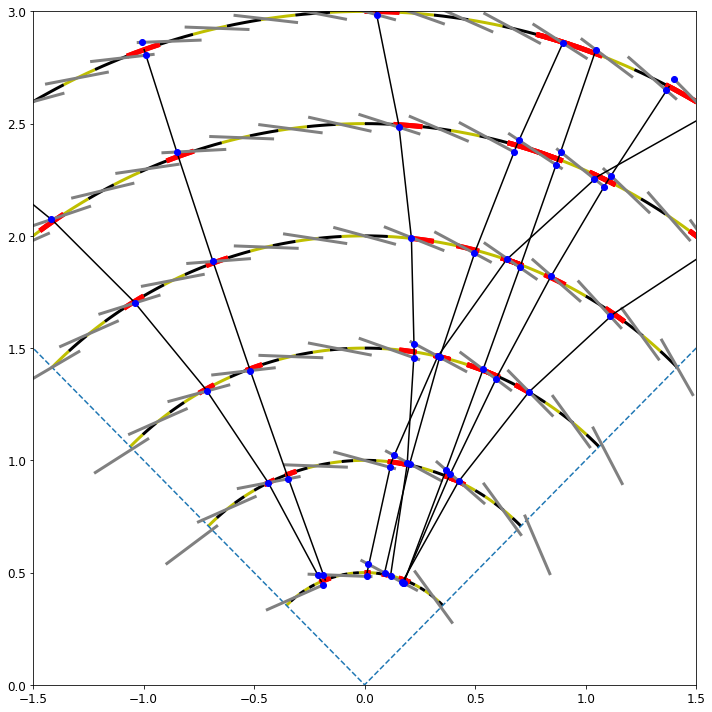

In [28]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_ylim((0, 3))
ax.set_xlim((-1.5, 1.5))


detGeo_up.drawTower(ax,detailed=True)
for mp in matchedPatterns_up:
    thisSSIDs = getSSIDS(mp)
    detGeo_up.drawSSIDs(ax,thisSSIDs)
    
for sItr in range(len(solutions_up)):
    s = solutions_up[sItr]

    color = "k"
    plt.plot(s[0],s[1],color)

    realHits = s[6]
    for rHit in realHits:
        plt.plot(rHit[1],rHit[2],"bo")
    
save_fig("MatchedPatternsPhi0p5Pi")

In [29]:
solns_up, _  = detGeo_up.getSolutions(matchedPatterns_up)
truth_up = getTruthDF(eventTruth_up)


In [30]:
score.score_event(truth_up,solns_up)

0.8275862068965518

# OK pretty clear differnet regions are working, lets to the whole event

Get full event

In [31]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((-3.5, 3.5))
ax.set_ylim((-3.5, 3.5))

detGeo_All = detectorGeo()
detGeo_All.initSimple(rDet,nModPerLayer)
detGeo_All.makeTower(0,  2*np.pi, nSS=nSSperLayer)

detGeo_All.drawDetector(ax)

recHits_All, eventTruth_All, eventPartilces_All, solutions_All = getEvent(50, 0, 2*np.pi, detGeo_All,randSeed=2)


for sItr in range(len(solutions_All)):
    s = solutions_All[sItr]
    


    color = "b" if (s[4] < 0) else "r"
    plt.plot(s[0],s[1],color)
    

/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:133: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:134: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_pm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_p_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:135: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mp = abs(yints_raw-trk_yc+np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))
/Users/johnda/MachineLearning/TrackingToy/TrackHelper.py:136: RuntimeWarning: invalid value encountered in sqrt
  closure_raw_mm = abs(yints_raw-trk_yc-np.sqrt(trk_rc2-(xints_m_raw-trk_xc)**2))


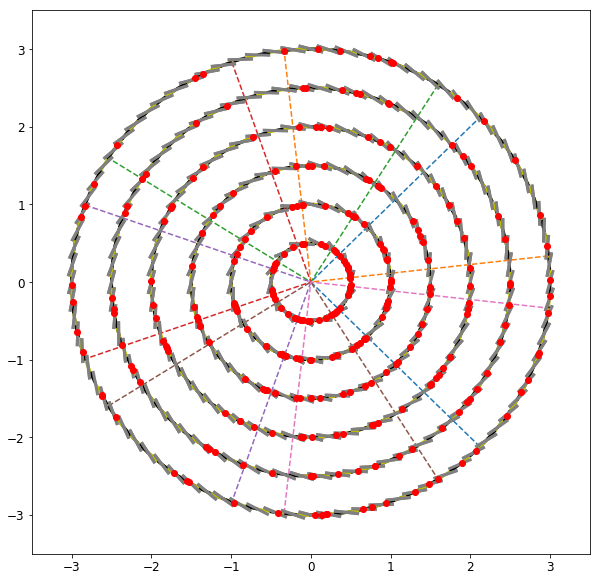

In [32]:

fig, ax = plt.subplots(1, figsize=(10,10))
ax.set_xlim((-3.5, 3.5))
ax.set_ylim((-3.5, 3.5))
nTowers = 7
towerWidth = np.pi/2

towers = []
for iT in range(nTowers):
    towers.append(detectorGeo())
    towers[-1].initSimple(rDet,nModPerLayer)
    towers[-1].makeTower(2*iT*np.pi/nTowers, towerWidth, nSS=nSSperLayer)

    towers[-1].drawTower(ax,detailed=True)

for sItr in range(50):
    s = solutions_All[sItr]

    color = "b" if (s[4] < 0) else "r"
    plt.plot(s[0],s[1],"ro")

In [33]:
import pandas as pd

evt_id_all = []
hit_id_all = []
trk_id_all = []

patterns = patternBank.keys()

for t in towers:
    hitsAndSSIDS_All = t.addSSIDs(recHits_All,filterOnTower=True)
    t.DOWrite(hitsAndSSIDS_All)


    thisMatchedPatterns = []
    for p in patterns:

        if t.isPatternFired(p): 
            thisMatchedPatterns.append(p)
    
    if len(trk_id_all): trkID = trk_id_all[-1]+1
    else:               trkID = 0
    
    thisSolns, thisSolnsDetails = t.getSolutions(thisMatchedPatterns,trkIDInit=trkID)
    
    # need over lap removal!
    
    evt_id_all += thisSolnsDetails[0]
    hit_id_all += thisSolnsDetails[1]
    trk_id_all += thisSolnsDetails[2]    

solnDictAll = {"event_id" : pd.Series(evt_id_all),
               "hit_id" : pd.Series(hit_id_all),
               "track_id" : pd.Series(trk_id_all),
              }

solnsAll = pd.DataFrame(solnDictAll)

In [34]:
truth_All = getTruthDF(eventTruth_All)
score.score_event(truth_All,solnsAll)

0.7032967032967034

In [35]:
solnsAll["hit_id"].value_counts()

362    2
207    2
60     2
59     2
285    2
286    2
132    2
133    2
210    2
290    2
209    2
293    2
206    2
62     2
205    2
204    2
203    2
300    2
136    2
137    2
304    2
305    2
306    2
138    2
61     2
63     2
41     2
231    2
99     2
104    2
      ..
248    1
249    1
250    1
251    1
252    1
253    1
254    1
255    1
256    1
257    1
258    1
243    1
242    1
241    1
227    1
219    1
220    1
221    1
223    1
224    1
226    1
228    1
240    1
229    1
230    1
234    1
237    1
238    1
239    1
0      1
Name: hit_id, Length: 338, dtype: int64